In [1]:
import pandas as pd
import numpy as np
import os

# Ajustar diretório
os.chdir(r"C:\Users\DELL\Documents\bank-analyst-project")

# Carregar features
df = pd.read_csv("data/processed/features_table.csv")
df.head()


,customer_id,recency_days,frequency,monetary,products_count,churn_90d
0,1,123.0,3.0,5754.60,0,0
1,2,92.0,3.0,9871.74,0,0
2,3,62.0,5.0,10495.10,0,0
3,4,31.0,4.0,6433.98,0,1
4,5,62.0,4.0,8384.69,0,0


In [2]:
from sklearn.model_selection import train_test_split

# Exemplo de split aleatório (temporal seria ideal na vida real)
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

print("Tamanho train:", len(train))
print("Tamanho test:", len(test))


Tamanho train: 800
Tamanho test: 200


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Escolher features disponíveis (ajuste conforme seu CSV)
feature_cols = ['recency_days','frequency','monetary','products_count']  # se não tiver age, não inclua
X_train = train[feature_cols].fillna(0)
y_train = train['churn_90d']
X_test = test[feature_cols].fillna(0)
y_test = test['churn_90d']

# Treinar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predição e AUC
preds = clf.predict_proba(X_test)[:,1]
auc_logistic = roc_auc_score(y_test, preds)
print("AUC Regressão Logística:", auc_logistic)


AUC Regressão Logística: 0.4286738351254481


In [4]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {"objective":"binary:logistic", "eval_metric":"auc", "seed":42}
bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dtest,'test')], early_stopping_rounds=20)

preds_xgb = bst.predict(dtest)
auc_xgb = roc_auc_score(y_test, preds_xgb)
print("AUC XGBoost:", auc_xgb)


[0]	test-auc:0.59692
[1]	test-auc:0.59670
[2]	test-auc:0.57427
[3]	test-auc:0.55649
[4]	test-auc:0.54903
[5]	test-auc:0.56029
[6]	test-auc:0.56337
[7]	test-auc:0.56495
[8]	test-auc:0.56172
[9]	test-auc:0.56115
[10]	test-auc:0.56122
[11]	test-auc:0.56939
[12]	test-auc:0.55341
[13]	test-auc:0.55685
[14]	test-auc:0.55842
[15]	test-auc:0.56315
[16]	test-auc:0.56932
[17]	test-auc:0.57405
[18]	test-auc:0.56781
[19]	test-auc:0.57534
AUC XGBoost: 0.5751971326164873


In [5]:
def precision_at_k(y_true, y_score, k):
    idx = np.argsort(y_score)[::-1][:k]
    return y_true.iloc[idx].mean()

k = int(0.1 * len(y_test))  # top 10%
prec_log = precision_at_k(y_test.reset_index(drop=True), pd.Series(preds), k)
prec_xgb = precision_at_k(y_test.reset_index(drop=True), pd.Series(preds_xgb), k)

print("Precision@10% Regressão Logística:", prec_log)
print("Precision@10% XGBoost:", prec_xgb)


Precision@10% Regressão Logística: 0.2
Precision@10% XGBoost: 0.35


C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


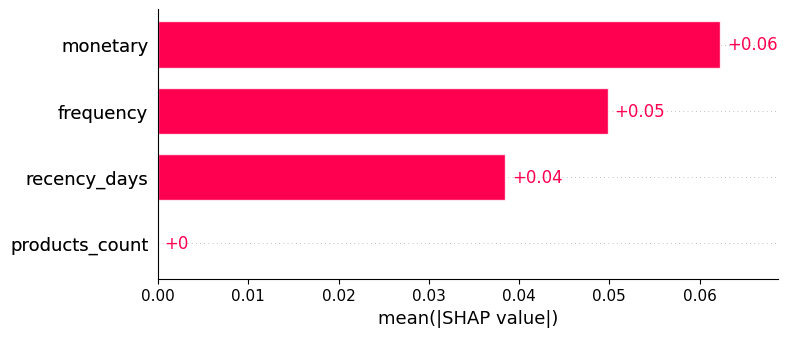

In [6]:
import shap

explainer = shap.Explainer(bst)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)


In [7]:
import joblib

# Regressão Logística
joblib.dump(clf, "models/logistic_churn.pkl")

# XGBoost
bst.save_model("models/xgb_churn.json")

print("✅ Modelos salvos em 'models/'")


✅ Modelos salvos em 'models/'


In [8]:
# Copiar o test set
df_test = test.copy().reset_index(drop=True)

# Adicionar as probabilidades do modelo XGBoost
df_test['pred'] = preds_xgb

# Visualizar os primeiros clientes com maior probabilidade de churn
df_test.sort_values('pred', ascending=False).head(10)


,customer_id,recency_days,frequency,monetary,products_count,churn_90d,pred
75,290,274.0,2.0,6579.48,0,0,0.869187
53,579,31.0,4.0,5842.89,0,0,0.677111
159,885,62.0,5.0,5858.10,0,1,0.577713
58,222,62.0,4.0,6192.38,0,1,0.543893
79,308,62.0,4.0,6174.09,0,1,0.508864
100,717,31.0,7.0,22909.22,0,0,0.475864
26,102,31.0,8.0,23213.09,0,0,0.470501
119,295,212.0,1.0,4078.08,0,1,0.464670
64,605,274.0,1.0,3177.22,0,0,0.450589
66,663,0.0,4.0,6628.85,0,0,0.447837


In [9]:
# Top 10% clientes para campanha
top_k = df_test.sort_values('pred', ascending=False).head(int(0.1 * len(df_test)))
print("Número de clientes selecionados:", len(top_k))
top_k.head()


Número de clientes selecionados: 20


,customer_id,recency_days,frequency,monetary,products_count,churn_90d,pred
75,290,274.0,2.0,6579.48,0,0,0.869187
53,579,31.0,4.0,5842.89,0,0,0.677111
159,885,62.0,5.0,5858.10,0,1,0.577713
58,222,62.0,4.0,6192.38,0,1,0.543893
79,308,62.0,4.0,6174.09,0,1,0.508864


In [10]:
# Taxa de conversão estimada e ticket médio
conversion_rate = 0.10  # 10%
ticket = 200  # R$200 por cliente convertido


In [11]:
estimated_revenue = len(top_k) * conversion_rate * ticket
print("Receita estimada com top-K:", estimated_revenue)


Receita estimada com top-K: 400.0


In [12]:
# Seleção aleatória de mesmo tamanho
random_sample = df_test.sample(len(top_k), random_state=42)
revenue_random = len(random_sample) * conversion_rate * ticket
print("Receita estimada com abordagem aleatória:", revenue_random)


Receita estimada com abordagem aleatória: 400.0


In [13]:
conversion_rates = [0.05, 0.10, 0.20]
tickets = [150, 200, 300]

for conv in conversion_rates:
    for t in tickets:
        rev_model = len(top_k) * conv * t
        rev_random = len(random_sample) * conv * t
        print(f"Conv={conv*100:.0f}%, Ticket=R${t}: Receita top-K={rev_model}, Receita random={rev_random}")


Conv=5%, Ticket=R$150: Receita top-K=150.0, Receita random=150.0
Conv=5%, Ticket=R$200: Receita top-K=200.0, Receita random=200.0
Conv=5%, Ticket=R$300: Receita top-K=300.0, Receita random=300.0
Conv=10%, Ticket=R$150: Receita top-K=300.0, Receita random=300.0
Conv=10%, Ticket=R$200: Receita top-K=400.0, Receita random=400.0
Conv=10%, Ticket=R$300: Receita top-K=600.0, Receita random=600.0
Conv=20%, Ticket=R$150: Receita top-K=600.0, Receita random=600.0
Conv=20%, Ticket=R$200: Receita top-K=800.0, Receita random=800.0
Conv=20%, Ticket=R$300: Receita top-K=1200.0, Receita random=1200.0


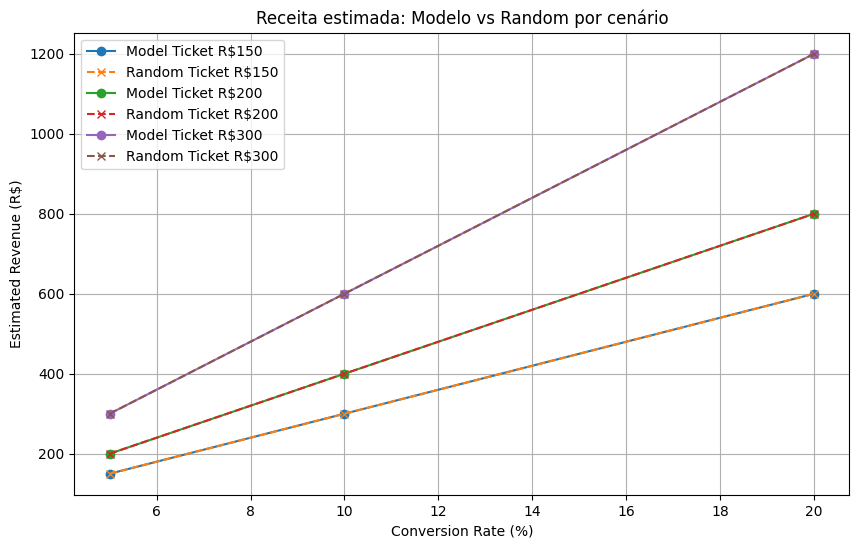

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Listas de cenários
conversion_rates = [0.05, 0.10, 0.20]
tickets = [150, 200, 300]

# Guardar resultados
results = []

for conv in conversion_rates:
    for t in tickets:
        rev_model = len(top_k) * conv * t
        rev_random = len(random_sample) * conv * t
        results.append({
            'Conversion Rate': conv,
            'Ticket': t,
            'Revenue Model': rev_model,
            'Revenue Random': rev_random
        })

# Transformar em DataFrame
df_results = pd.DataFrame(results)

# Plot
fig, ax = plt.subplots(figsize=(10,6))

for t in tickets:
    subset = df_results[df_results['Ticket'] == t]
    ax.plot(subset['Conversion Rate']*100, subset['Revenue Model'], marker='o', label=f'Model Ticket R${t}')
    ax.plot(subset['Conversion Rate']*100, subset['Revenue Random'], marker='x', linestyle='--', label=f'Random Ticket R${t}')

ax.set_xlabel("Conversion Rate (%)")
ax.set_ylabel("Estimated Revenue (R$)")
ax.set_title("Receita estimada: Modelo vs Random por cenário")
ax.legend()
ax.grid(True)
plt.show()

